# 1. AdaBoost

## 1.1 AdaBoost from scratch

In [1]:
import numpy as np 
from sklearn.tree import DecisionTreeClassifier

In [2]:
class AdaBoostScratch:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators #iter number
        self.alphas = [] #the model weights every round
        self.models = [] #store the weak model

    def fit(self, X, y):
        n_samples = X.shape[0]

        #init the sample weights
        w = np.ones(n_samples) / n_samples

        for r in range(self.n_estimators):
            #init stump to be depth-1 decision tree
            stump = DecisionTreeClassifier(max_depth=1)
            stump.fit(X, y, sample_weight=w)
            pred = stump.predict(X)

            #calculate the error ratio
            err = np.sum(w * (pred != y)) // np.sum(w)
            # 避免除 0 或 log(0)
            err = np.clip(err, 1e-10, 1 - 1e-10)

            #calculate the model weight
            alpha = 0.5 * np.log((1 - err) / err)

            #update the sample weight, increase the weight of wrong classified sample
            w *= np.exp(-alpha * y * pred)
            #normalize
            w /= np.sum(w)

            self.models.append(stump)
            self.alphas.append(alpha)

    def predict(self, X):
        clf_preds = np.array([alpha * model.predict(X) for model, alpha in zip(self.models, self.alphas)])
        #clf_preds shape (n_estimators, n_samples)
        y_pred = np.sign(np.sum(clf_preds, axis=0))
        #after sum over axis=0, give (n_samples,) shape
        return y_pred

    def predict_proba(self, X): #only good for binary classification
        scores = np.sum([alpha * model.predict(X) for model, alpha in zip(self.models, self.alphas)], axis=0)
        probs = 1 / (1 + np.exp(-2 * scores))  # sigmoid 映射
        return np.vstack([1 - probs, probs]).T

    def predict_proba(self, X):#for multiclass
        n_samples = X.shape[0]
        n_classes = len(set(np.concatenate([model.classes_ for model in self.models])))
    
        # 初始化每个类别的得分矩阵
        class_scores = np.zeros((n_samples, n_classes))
    
        # 遍历每个模型及其权重，累加每个样本在各类上的得分
        for model, alpha in zip(self.models, self.alphas):
            preds = model.predict(X)  # 返回 shape=(n_samples,), 每个值是 predicted class
            for i in range(n_samples):
                class_scores[i, preds[i]] += alpha
    
        # 对每个样本的类别得分应用 softmax → 转为概率
        exp_scores = np.exp(class_scores - np.max(class_scores, axis=1, keepdims=True))  # 防止数值爆炸
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    
        return probs  # shape: (n_samples, n_classes)

In [3]:
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import accuracy_score

# 二分类处理（只取前两类）
X, y = load_iris(return_X_y=True)
X = X[y != 2]
y = y[y != 2]
y = np.where(y == 0, -1, 1)  # 转为 {-1, 1}

# 拟合 AdaBoost
model = AdaBoostScratch(n_estimators=20)
model.fit(X, y)
y_pred = model.predict(X)

print("准确率：", accuracy_score(y, y_pred))

准确率： 1.0


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = AdaBoostScratch(n_estimators=20)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("测试集准确率：", accuracy_score(y_test, y_pred))

测试集准确率： 1.0


## for multiclass

In [5]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier

class AdaBoostScratch:
    def __init__(self, n_estimators=50):
        self.n_estimators = n_estimators
        self.models = []
        self.alphas = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.classes_ = np.unique(y)
        n_classes = len(self.classes_)

        # 初始化样本权重为平均分布
        w = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            model = DecisionTreeClassifier(max_depth=1)
            model.fit(X, y, sample_weight=w)
            pred = model.predict(X)

            # 计算加权错误率
            err = np.sum(w * (pred != y)) / np.sum(w)
            if err >= 1 - 1e-10 or err == 0:
                continue  # 跳过无效弱学习器

            # 计算模型的权重 α_t
            alpha = 0.5 * np.log((1 - err) / (err + 1e-10))

            # 更新样本权重 w_i
            w *= np.exp(-alpha * (y == pred) + alpha * (y != pred))
            w /= np.sum(w)

            self.models.append(model)
            self.alphas.append(alpha)

    def predict(self, X):
        """
        对每个类别加权投票，选择得分最高的类作为预测值
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        class_scores = np.zeros((n_samples, n_classes))  # 每个样本每个类别的得分

        for model, alpha in zip(self.models, self.alphas):
            preds = model.predict(X)  # 弱模型预测的类别
            for i in range(n_samples):
                class_index = np.where(self.classes_ == preds[i])[0][0]
                class_scores[i, class_index] += alpha  # 累加得分

        return self.classes_[np.argmax(class_scores, axis=1)]  # 返回得分最高的类别

    def predict_proba(self, X):
        """
        使用 softmax 将类别得分转为概率分布
        """
        n_samples = X.shape[0]
        n_classes = len(self.classes_)
        class_scores = np.zeros((n_samples, n_classes))

        for model, alpha in zip(self.models, self.alphas):
            preds = model.predict(X)
            for i in range(n_samples):
                class_index = np.where(self.classes_ == preds[i])[0][0]
                class_scores[i, class_index] += alpha

        # softmax 转换为概率
        exp_scores = np.exp(class_scores - np.max(class_scores, axis=1, keepdims=True))
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return probs


In [6]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 训练模型
model = AdaBoostScratch(n_estimators=30)
model.fit(X_train, y_train)

# 预测
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

# 评估
print("测试集准确率：", accuracy_score(y_test, y_pred))
print("前5个样本预测概率：\n", y_proba[:5])

测试集准确率： 1.0
前5个样本预测概率：
 [[0.00292074 0.87834509 0.11873417]
 [0.96858593 0.02987556 0.00153851]
 [0.0017305  0.0381298  0.9601397 ]
 [0.00355522 0.80433313 0.19211164]
 [0.00394967 0.73743595 0.25861438]]


## 1.2 Adaboost sklearn

In [9]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=1),
    n_estimators=50,
    learning_rate=1.0,
    algorithm='SAMME'
)
model.fit(X_train, y_train)

/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


,estimator,DecisionTreeC...r(max_depth=1)
,n_estimators,50
,learning_rate,1.0
,algorithm,'SAMME'
,random_state,None
,criterion,'gini'
,splitter,'best'
,max_depth,1
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [10]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
print(f"scores: {scores}")

scores: [0.96666667 0.96666667 0.93333333 0.9        1.        ]


/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/mamba/Documents/MOOC/ML/env/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(
/Users/mamba/Documents/MOOC/ML/env/lib/pytho

# 2. Gradient boosting decision tree

## 2.1 GBDT sklearn

### 2.1.1 Regression

In [11]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [12]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
model = GradientBoostingRegressor(
    n_estimators=100, #number of weak model
    learning_rate=0.1,
    max_depth=3, #every tree max depth
    random_state=42
)

In [14]:
model.fit(X_train, y_train)

,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [15]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"均方误差 MSE: {mse:.2f}")
print(f"决定系数 R^2: {r2:.3f}")

均方误差 MSE: 2898.44
决定系数 R^2: 0.453


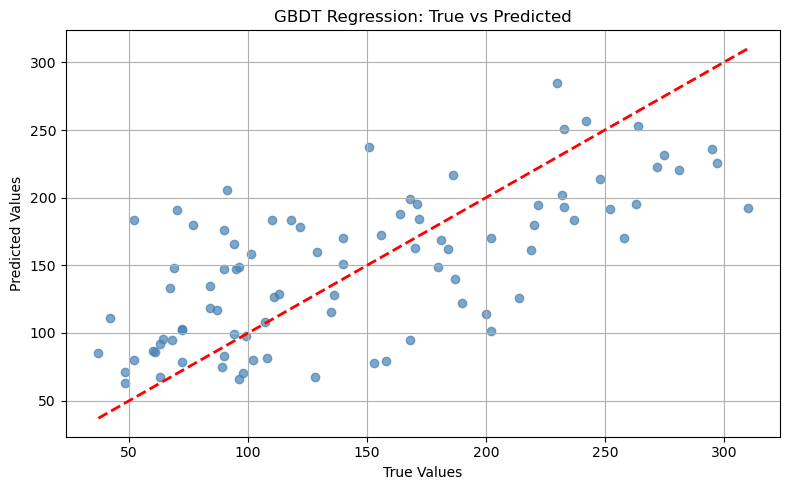

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.7, color='steelblue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('GBDT Regression: True vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()

### 2.1.2 Classification

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [19]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [20]:
model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

In [21]:
model.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [22]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"准确率 Accuracy: {acc:.3f}")

准确率 Accuracy: 0.933


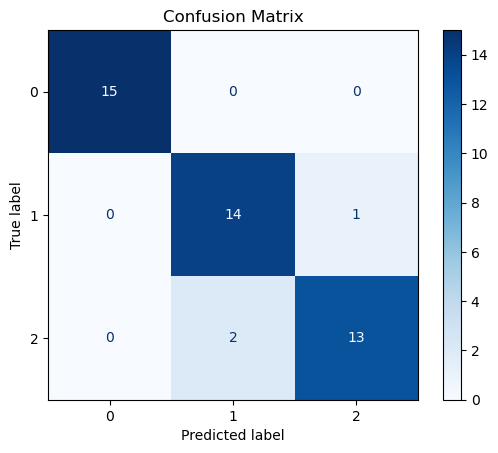

In [23]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

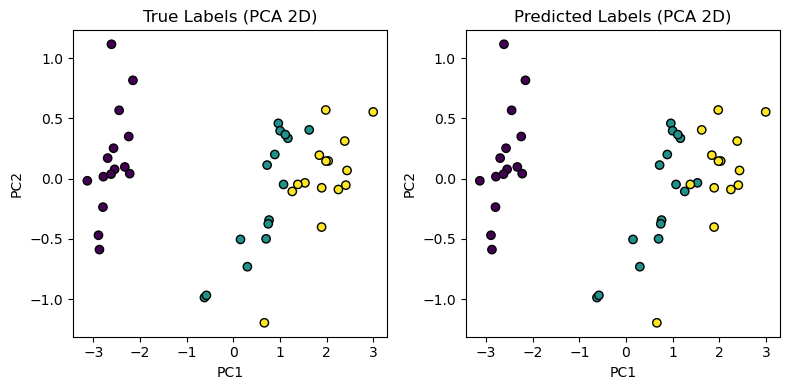

In [24]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)

plt.figure(figsize=(8, 4))

# True labels
plt.subplot(1, 2, 1)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_test, cmap='viridis', edgecolor='k')
plt.title("True Labels (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Predicted labels
plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred, cmap='viridis', edgecolor='k')
plt.title("Predicted Labels (PCA 2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()

## 2.2 GBDT numpy multiclass

In [25]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split


In [34]:
class GBDTMulticlassScratch:
    def __init__(self, n_estimators=50, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.models = []  # 每个类别一组回归树
        self.n_classes = None

    def _softmax(self, logits):
        exp_logits = np.exp(logits - np.max(logits, axis=1, keepdims=True))  # 防止溢出
        return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

    def fit(self, X, y):
        n_samples = X.shape[0]
        self.n_classes = np.unique(y).shape[0]

        # one-hot 编码真实标签
        y_onehot = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))

        # 初始化 logits
        logits = np.zeros((n_samples, self.n_classes))
        self.models = [[] for _ in range(self.n_classes)]

        # will train n_estimators for each class, so total is n_estimators * n_classes, those for loop can switch
        for _ in range(self.n_estimators): 
            probs = self._softmax(logits)
            for k in range(self.n_classes): #for each class will train a group of tree
                # 负梯度 = 真实值 - 当前概率
                residual = y_onehot[:, k] - probs[:, k]
                tree = DecisionTreeRegressor(max_depth=self.max_depth)
                tree.fit(X, residual)
                update = tree.predict(X)
                logits[:, k] += self.learning_rate * update
                self.models[k].append(tree)

    def predict_proba(self, X):
        n_samples = X.shape[0]
        logits = np.zeros((n_samples, self.n_classes))
        for k in range(self.n_classes):
            for tree in self.models[k]:
                logits[:, k] += self.learning_rate * tree.predict(X)
        return self._softmax(logits)

    def predict(self, X):
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)

In [35]:
X, y = load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# 拟合手写 GBDT
model = GBDTMulticlassScratch(n_estimators=50, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# 预测与评估
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {acc:.3f}")

Test Accuracy: 0.933


## 2.3 GBDT Regression

In [36]:
from sklearn.tree import DecisionTreeRegressor

class GradientBoostingRegressorScratch:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators      # 树的个数
        self.learning_rate = learning_rate    # 学习率
        self.max_depth = max_depth            # 每棵树的最大深度
        self.models = []                      # 存储每一棵回归树
        self.init_pred = None                 # 初始常数预测值（均值）

    def fit(self, X, y):
        # Step 1: 初始预测为常数：y 的均值
        self.init_pred = np.mean(y)
        y_pred = np.full_like(y, self.init_pred, dtype=float)

        for _ in range(self.n_estimators):
            # Step 2: 计算残差
            residual = y - y_pred

            # Step 3: 用回归树拟合残差
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residual)

            # Step 4: 更新预测值
            update = tree.predict(X)
            y_pred += self.learning_rate * update

            # 保存模型
            self.models.append(tree)

    def predict(self, X):
        # 初始预测值
        y_pred = np.full((X.shape[0],), self.init_pred, dtype=float)
        for tree in self.models:
            y_pred += self.learning_rate * tree.predict(X)
        return y_pred

In [37]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# 加载数据
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 训练模型
model = GradientBoostingRegressorScratch(n_estimators=100, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

# 预测与评估
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("测试集 MSE：", mse)

测试集 MSE： 2908.1473006764336
